# Tutorial: Own Problems and Models for Evolutionary Optimization
*01/2021: updated to pyGDM v1.1+*

This tutorial demonstrates how to define own geometry models and optimization problems using the **EO** module of pyGDM. The evolutionary optimization module interfaces <a href="https://esa.github.io/pygmo2/" title="pagmo/pygmo">pagmo/pygmo</a>, which needs to be installed (available via pip). 

 - We will create a very simple model with only two free parameters: A cuboidal antenna of fixed height. The free parameters shall be the width and length of the rectangular cross-section.

 - The problem we'll implement below will be the maximization of the scattering cross-section.
 

We start by loading the modules we'll use

In [1]:
import numpy as np

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields

from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import linear
from pyGDM2 import tools
from pyGDM2 import visu

## --- the main EO routine
from pyGDM2.EO.core import run_eo

## Implementing a Geometry Model

We will implement a very simple model based on the `rect_wire` geometry in the `structures` module. The free parameters will be length and width of the rod, the height shall be fixed.


In [2]:
from pyGDM2.EO.models import BaseModel

class ownModel(BaseModel):
    """optimization-model for a rectangular antenna
    
    Notes
    -----
    The purpose of this model is only for demonstration. A problem with only 
    two free parameters can more easily be solved by systematic analysis of 
    all possible permutations (brute-force)
    
    A user-defined model must at least implement the following three 
    methods:
    
     - `__init__(self, sim, **kwargs)` (constructor)
     
     - `get_bounds(self)` (optimization parameter box-boundaries)
     
     - `generate_structure(self, params)` (geometry generator)
    """
    
    def __init__(self, sim, limits_W, limits_L, height):
        """
        Mandatory actions in the constructor are:
        
         - the constructor of the parent class "BaseModel" must be called 
           with the `simulation` object defining the pyGDM simulation part
           
         - call `self.random_structure()`, which is defined in "BaseModel"
        """
        ## --- call BaseModel constructor, pass at least the "simulation" instance
        super(self.__class__, self).__init__(sim)
        
        ## --- width and length limits for rectrangular antenna
        self.limits_W = limits_W
        self.limits_L = limits_L
        
        ## --- fixed parameters
        self.height = height    # height of rectangular antenna
        
        ## --- init with random values. `random_structure` is defined in `BaseModel`
        self.random_structure()
    
    
    def get_bounds(self):
        """Return lower and upper boundaries for parameters
        
        Both of the lower/upper boundary lists must contain a value
        for each free parameter. In our case (2 free parameters), thus 
        the two lists contain 2 elements each: The box-boundaries for 
        the width and length of the rectangle.
        """
        self.lbnds = [self.limits_W[0], self.limits_L[0]]
        self.ubnds = [self.limits_W[1], self.limits_L[1]]
        
        return self.lbnds, self.ubnds
    
    
    def generate_structure(self, params):
        """generate the structure
        
        This method implements the actual structure generation as 
        function of the free parameters, passed as numpy array `params`.
        
        The geometry is generated as a list of mesh-point positions 
        (list/array of 3D-coordinate tuples (x,y,z)).
        The structure must be internally set using `self.set_structure()`,
        the latter being defined in `BaseModel`.
        """
        ## --- the order of `params` must correspond to 
        ##     the boundary order, used in `get_bounds`
        W, L = params[0], params[1]
        
        ## --- generate the structure geometry: rectangular nano-rod
        from pyGDM2 import structures
        geometry = structures.rect_wire(self.sim.struct.step, L, self.height, W)
        
        ## --- mandatory call: set new structure-geometry 
        ##     (`set_structure` is a `BaseModel` method)
        self.set_structure(geometry)

## Implementing an Optimization Problem

We will also implement a simple problem for optimization. 
We want to find a structure geometry (in this demonstration: The optimum dimensions of the rectangular rod), **maximizing the scattering cross-section** under plane wave illumination for a specific wavelength and polarization.
You will see below, that this is very simple. The problem of maximizing the scattering cross-section is defined by only **8 lines of actual code**.

***Note:*** pyGDM assumes that the **objective function is to be *maximized***. The <a href="https://esa.github.io/pagmo2/" title="pygmo">pygmo</a> package assumes *minimization*, thus internally the objective function will be multiplied by *-1* to effectively render the maximization to a minimization task. If you want to implement a minimization, you might apply the same trick: use the negative of the target value(s) as objective function.


In [3]:
from pyGDM2.EO.problems import BaseProblem

class ownProblem(BaseProblem):
    """Problem to maximize scattering cross-section (SCS) of nano-structure
    
    Notes
    -----
    A user-defined problem must at least implement the following methods:
    
     - `__init__(self, model, **kwargs)` (constructor)
     
     - `objective_function(self, params)` (optimization target)
    """
    
    def __init__(self, model):
        """
        In the Problem constructor, the constructor of the parent 
        class "BaseProblem" must be called, passing the `model` object.
        """
        super(self.__class__, self).__init__(model)
    
    
    def objective_function(self, params):
        """calculate the scattering cross-section
        
        This method implements the actual optimization problem by
        calculating the objective function, also often called "fitness".
        The objective function returns the optimization target as
        function of the parameter-set `params`.
        
        The fitness will usually be calculated as follows:
        
        - (1) the structure generator is called with the parameter-
              vector `params` (which is provided by the 
              optimization algorithm)
        
        - (2) a pyGDM simulation is performed using the model-geometry
              defined by the parameters `params`
              
        - (3) the pyGDM results are evaluated and the result returned.
              Below, we calculate the scattering cross-section of the
              considered particle.
        
        """
        ## --- generate structure definded by `params`
        self.model.generate_structure(params)
        
        ## --- GDM sim. / cross-section calculation (field_index=0)
        core.scatter(self.model.sim, verbose=False)
        ext_cs, sca_cs, abs_cs = linear.extinct(self.model.sim, 0)
        
        return float(sca_cs)

## Running the Optimization

Now, let's test our user-defined model and problem. 
Let's search for the rectangular antenna geometry that optimally scatters light of $1\,\mu$m wavelength.

### Setup the pyGDM-Simulation


We setup a pyGDM simulation just as usual, with the only difference, that the geometry is left blank, since this will be varied and determined during the optimization by the model-class, we defined above.

In [4]:
## --- Setup structure
mesh = 'cube'
step = 20
material = materials.gold()  # particle material

## Empty dummy-geometry, will be replaced on run-time by EO-model
geometry = []       
struct = structures.struct(step, geometry, material)


## --- Setup incident field
field_generator = fields.planewave        # planwave excitation
kwargs = dict(theta = [0.0])              # single (linear) polarization
wavelengths = [1000]                      # single wavelength
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)


## --- environment
n1, n2 = 1.0, 1.0            # in vacuum
dyads = propagators.DyadsQuasistatic123(n1=n1, n2=n2)


## --- Simulation initialization
sim = core.simulation(struct, efield, dyads)

structure initialization - consistency check: 0/0 dipoles valid


/home/hans/.local/lib/python3.8/site-packages/pyGDM2/structures.py:183: UserWarning: Emtpy structure geometry.
  warnings.warn("Emtpy structure geometry.")


### Setup the Evolutionary Optimization

After having defined the simulation conditions, we need to setup the particle geometry, the target problem and evolutionary optimization algorithm.

- The geometry will be provided by our model class `ownModel`
- The problem is defined in our class `ownProblem`
- The evolutionary optimization algorithm needs to be one of the <a href="https://esa.github.io/pygmo2/" title="pygmo">pygmo</a> package


In [5]:
# =============================================================================
# structure model
# =============================================================================
model   = ownModel(sim, limits_W=[2,20], limits_L=[2,20], height=1)


# =============================================================================
# optimization problem
# =============================================================================
problem = ownProblem(model)


# =============================================================================
# setup optimization algorithm
# =============================================================================
## --- size of population
population = 15          # Nr of individuals

## --- stop criteria
max_time = 60            # seconds
max_iter = 20            # max. iterations
max_nonsuccess = 5       # max. consecutive iterations without improvement

## --- other config
generations = 1          # Nr of generations to evolve between status reports
save_all_generations = False
filename = "own_problem.eo" # path to file to save results (optional)

## Use algorithm "sade" (jDE variant, a self-adaptive
##                      form of differential evolution)
import pygmo as pg
algorithm = pg.sade
algorithm_kwargs = dict()   # optional kwargs, to be passed to the algorithm


# =============================================================================
# run the optimization
# =============================================================================
eo_dict = run_eo(problem,
                 population=population,
                 algorithm=algorithm,
                 generations=generations, 
                 max_time=max_time, 
                 max_iter=max_iter, 
                 max_nonsuccess=max_nonsuccess,
                 filename=filename)


----------------------------------------------
 Starting new optimization
----------------------------------------------




/home/hans/.local/lib/python3.8/site-packages/pyGDM2/tools.py:835: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")
/home/hans/.local/lib/python3.8/site-packages/numba/core/dispatcher.py:237: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  entrypoints.init_all()
/home/hans/.local/lib/python3.8/site-packages/pyGDM2/tools.py:835: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")


iter #  1, time:    3.4s, progress #  1, f_evals: 30
        - champion fitness: [-305220.0]

iter #  2, time:    7.2s, progress #  2, f_evals: 45
        - champion fitness: [-481860.0]

iter #  3, time:   10.9s, progress #  2, f_evals: 60(non-success: 1)
iter #  4, time:   14.7s, progress #  2, f_evals: 75(non-success: 2)
iter #  5, time:   18.4s, progress #  2, f_evals: 90(non-success: 3)
iter #  6, time:   22.2s, progress #  2, f_evals: 105(non-success: 4)
iter #  7, time:   25.8s, progress #  2, f_evals: 120(non-success: 5)

 -------- maximum non-successful iterations reached


## Analyze and plot the results

`pyGDM.EO.tools` offers several tools for rapid and simple reloading of the optimization results. We will use `get_best_candidate` to obtain the final best solution of the optimization.
This function returns the pyGDM `simulation` object containing the optimum geometry:

Best candidate after 3 iterations (with 1 improvements): fitness = ['-4.8186e+05']
Testing: recalculating fitness...Done. Everything OK.

 =============== GDM Simulation Information ===============
precision: <class 'numpy.float32'> / <class 'numpy.complex64'>


 ------ nano-object -------
   Homogeneous object. 
   material:             "Gold, Johnson/Christy"
   mesh type:            cubic
   nominal stepsize:     20nm
   nr. of meshpoints:    209

 ----- incident field -----
   field generator: "planewave"
   1 wavelengths between 1000 and 1000nm
   1 incident field configurations per wavelength

 ------ environment -------
   n3 = constant index material, n=(1+0j)  <-- top
   n2 = constant index material, n=(1+0j)  <-- center layer (height "spacing" = 5000nm)
   n1 = constant index material, n=(1+0j)  <-- substrate

 ===== *core.scatter* ======
   self-consistent E-fields are available
   NO self-consistent H-fields


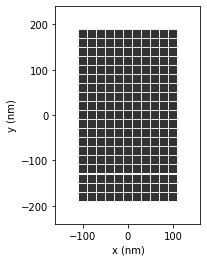

In [6]:
## --- some more imports
import copy
import matplotlib.pyplot as plt
from pyGDM2 import EO

## --- get the best candidate from the optimization
sim = EO.tools.get_best_candidate(eo_dict, verbose=True)

print(sim)
visu.structure(sim)

## Calculate a Scattering Spectrum for the Resulting Structure

We hope to have obtained a nano-antenna, resonant at the target wavelength (in our case $1\mu$m). To check this, we would like to compute the scattering spectrum of the structure.
Since the optimization `simulation` object was defined for only one single illumination wavelength, we need to create a new pyGDM simulation instance:

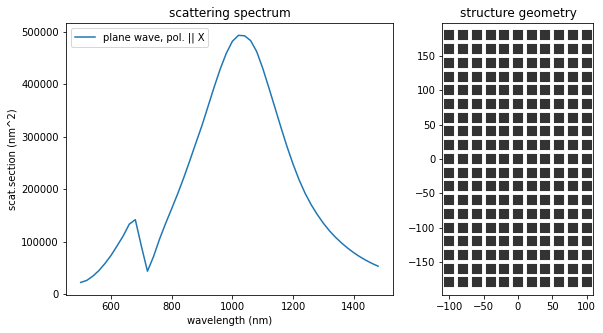

In [7]:
#==============================================================================
# setup new simulation to calculate spectrum
#==============================================================================
## --- structure
struct = copy.deepcopy(sim.struct)

## --- incident field
field_generator = fields.planewave        # planwave excitation
wavelengths = np.arange(500, 1500, 20)  # spectrum
kwargs = dict(theta = [0.0, 90.0])          # 0/90 deg polarizations
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)
dyads = propagators.DyadsQuasistatic123(n1=1, n2=1)  # vacuum

## --- spectrally resolved simulation
sim_spectrum = core.simulation(struct, efield, dyads)


#==============================================================================
# run simulation for the spectrum
#==============================================================================
core.scatter(sim_spectrum, verbose=0)

## --- scattering spectrum
field_kwargs = tools.get_possible_field_params_spectra(sim_spectrum)[0]
wl, spec_ext0 = tools.calculate_spectrum(sim_spectrum, field_kwargs, linear.extinct)
asca0 = spec_ext0.T[1]

## --- plot
plt.figure(figsize=(10,5))

plt.subplot2grid((1,5), (0,0), colspan=3)
plt.title("scattering spectrum")
plt.plot(wl, asca0, label="plane wave, pol. || X")
plt.legend(loc='best', fontsize=10)
plt.xlabel("wavelength (nm)")
plt.ylabel("scat.section (nm^2)")

plt.subplot2grid((1,5), (0,3), colspan=2, aspect="equal")
plt.title('structure geometry')
visu.structure(sim_spectrum, show=False)
    
plt.show()

The structure found by evolutionary optimization has indeed a scattering resonance at $1000\,$nm wavelength. Furthermore, since we aimed to maximize the *cross-section*, the $Y$-dimension of the rectangle is chosen as large as possible (within the allowed limits), to increase the cross-section.
Maximizing the scattering *efficiency* instead, would lead to a very narrow antenna of same length, in order to reduce the geometric cross-section.


## *Note:* Technical Detail
Most EO-tools can be called either with the `eo_dict` as obtained by `run_eo` or with the filename to the stored optimizaiton results. In fact, the saved file is just a pickled version of the return python dictionary `eo_dict`.
For instance,

In [8]:
sim = EO.tools.get_best_candidate(eo_dict, verbose=True)

Best candidate after 3 iterations (with 1 improvements): fitness = ['-4.8186e+05']
Testing: recalculating fitness...Done. Everything OK.


is equivalent to calling `get_best_candidate`, giving the path to the stored results:

In [9]:
filename = "own_problem.eo" # path to saved EO results
sim = EO.tools.get_best_candidate(filename, verbose=True)

Best candidate after 3 iterations (with 1 improvements): fitness = ['-4.8186e+05']
Testing: recalculating fitness...Done. Everything OK.
